# MITGCM Regional Spatial Scale Analysis 

**Purpose**: Code for preforming the regional spatial scale analysis. I will compute the decorrelation length scale for a subset of the model domain in the along- and across-isobath coordinate. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [3]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.dates as mdates

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [4]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density
option_depth         = 99.0

# Set time and space parameters
L            = 1.5                           # Specifies the distance between points (assumes that ds = dn)
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 12

Load intermediate mitgcm data (coordinate transformed)

In [5]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "mitgcm_coord_transform_sn_temp_isobath_2000_res_" + str(L) + "_depth_99.0m.npz"
elif option_var == 'sal':
    filename = PATH + "mitgcm_coord_transform_sn_sal_isobath_2000_res_" + str(L) + ".npz"
elif option_var == 'density':
    filename = PATH + "mitgcm_coord_transform_sn_rho_isobath_2000_res_" + str(L) + ".npz"

# Load data 
data_struct = np.load(filename, allow_pickle=True)

# Extract data variables
s_coord    = data_struct["s"]
n_coord    = data_struct["n"]
time       = data_struct["time"]
data       = data_struct["data"]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Plot the spatial domain

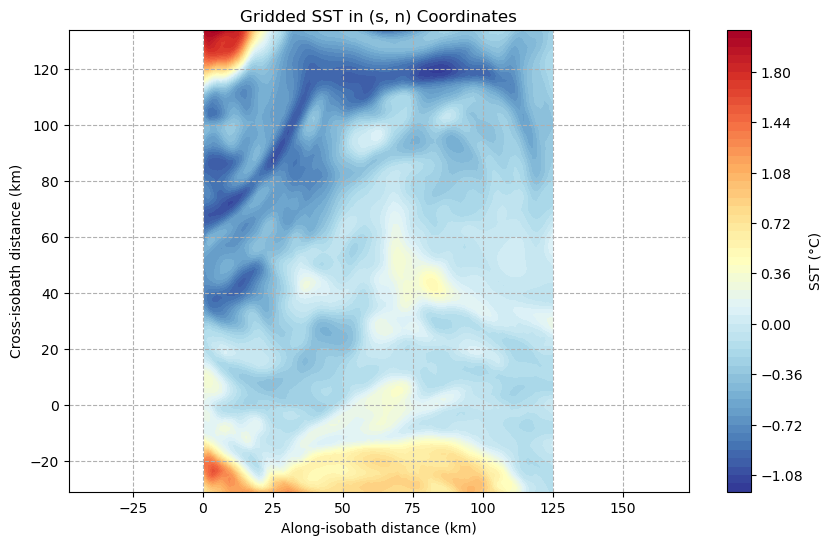

In [6]:
# Set plotting parameters
S, N = np.meshgrid(s_coord, n_coord)

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord, n_coord, data[1,:,:].T, cmap='RdYlBu_r',levels=60)

# Set figure attributes
plt.title('Gridded SST in (s, n) Coordinates')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.colorbar(label='SST (°C)')
plt.grid(True,linestyle='--')
plt.axis('equal')

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + 'Temperature_sn_map', bbox_inches = 'tight', dpi=300)

Preform scale analysis

This will take a few forms: 

1. Compute the along-isobath decorrelation scale as a function of cross-isobath distance ($\delta_s$): This will show how the length scales along isobaths vary with distance from shore. 

2. Compute the cross-isobath decorrelation scale as a function of along isobath distance ($\delta_n$): This will show how the length scales across isobath vary along the coast. **Note**: The draw back from this approach is that the cross-isobath domain spans multiple regimes from off-shelf to on-shelf. Approach 3 address this. 

3. Compute the cross-isobath decorrelation scale for the three regimes, (1) on-shelf, (2) off-shelf, and (3) the transition region on the shelf break.

### Approach 1 : Along-isobath decorrelation $\delta_s(n,t)$

In [7]:
# Set parameters
ntime,nS,nN = np.shape(data)              # Dimensions of the data array 
lag = nS                                  # Number of lagged steps for the autocorrelation function 

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Convert data to a masked array 
mask = np.zeros_like(data, dtype=bool)
data_m = np.ma.masked_array(data, mask=mask)

# Initialize arrays 
autocorr_tn     = np.zeros((ntime,nS,nN))
length_scale_tn = np.zeros((ntime,nS,nN))
delta_s         = np.zeros((ntime,nN))
cn_time         = 0 

# Loop through time at time increment steps
for itime in range(0,ntime): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set cross-isobath counter  
    cn_n = 0

    # Loop through n-coordinate 
    for in_coord in range(0,nN): 

        # Obtain the s-coordinate record at the ith time step and jth n-coordinate 
        data_s = data_m[itime,:,in_coord]

        # Detrend data record (removing the mean)
        data_dt = detrend(data_s, s_coord, mean = 0)

        # Compute autocorrelation function of s-coordinate dimenstion
        autocorr_tn[cn_time,:,cn_n], _, _, _, length_scale_tn[cn_time,:,cn_n], _ = compute_autocorr(data_dt, s_coord, lag, estimator, 0)

        # Compute the along isobath decorrelation scale
        delta_s[cn_time,cn_n] = compute_decor_scale(autocorr_tn[cn_time,:,cn_n],length_scale_tn[cn_time,:,cn_n],L,estimator,0)

        # Set latitude counter
        cn_n = cn_n + 1

    # Set cross-isobath counter
    cn_time = cn_time + 1


Progress: 100.0%

In [8]:
# Average in time and n-coordinate respectively
autocorr_mtime = np.mean(autocorr_tn,axis=0)
autocorr_mn = np.mean(autocorr_tn,axis=2)
dist_scale_mtime = np.mean(length_scale_tn,axis=0)
dist_scale_mn = np.mean(length_scale_tn,axis=2)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_stdmtime = np.std(autocorr_tn,axis=0,ddof=1)/np.sqrt(autocorr_tn.shape[0])
autocorr_stdmn = np.std(autocorr_tn,axis=2,ddof=1)/np.sqrt(autocorr_tn.shape[2])

#--- Time ---# 

# Initialize arrays
delta_s_mt    = np.zeros((len(n_coord)))
delta_s_stdmt = np.zeros((len(n_coord)))

# Loop through n-coordinate
for iN in range(0,len(n_coord)):

    # Compute the along-isobath decorrelation scale
    delta_s_mt[iN]  = compute_decor_scale(autocorr_mtime[:,iN],dist_scale_mtime[:,iN],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_s_ustd = compute_decor_scale(autocorr_mtime[:,iN] + autocorr_stdmtime[:,iN] ,dist_scale_mtime[:,iN] ,L,estimator,0)
    delta_s_lstd = compute_decor_scale(autocorr_mtime[:,iN] - autocorr_stdmtime[:,iN] ,dist_scale_mtime[:,iN] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_s_ustd - delta_s_mt[iN]
    std_lower = abs(delta_s_lstd - delta_s_mt[iN])
    delta_s_stdmt[iN]  = np.mean([std_upper, std_lower])

#--- n-coordinate ---# 

# Initialize arrays
delta_s_mn    = np.zeros((len(time_dt)))
delta_s_stdmn = np.zeros((len(time_dt)))

# Loop through n-coordinate
for itime in range(0,len(time_dt)):

    # Compute the along-isobath decorrelation scale
    delta_s_mn[itime]  = compute_decor_scale(autocorr_mn[itime,:],dist_scale_mn[itime,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_s_ustd = compute_decor_scale(autocorr_mn[itime,:] + autocorr_stdmn[itime,:] ,dist_scale_mn[itime,:] ,L,estimator,0)
    delta_s_lstd = compute_decor_scale(autocorr_mn[itime,:] - autocorr_stdmn[itime,:] ,dist_scale_mn[itime,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_s_ustd - delta_s_mn[itime]
    std_lower = abs(delta_s_lstd - delta_s_mn[itime])
    delta_s_stdmn[itime]  = np.mean([std_upper, std_lower])

Compute monthly averages to look for seasonality in the along-isobath decorrelation scale

In [9]:
# Set the year and month time array
years = np.array([y.year for y in time_dt])
months = np.array([m.month for m in time_dt])

# Find unique years and months
unique_years = np.unique(years) 
unique_months = np.unique(months) 

# Find the number of months in time series
year_month_pairs = np.array([(t.year, t.month) for t in time_dt])
num_unique_months = len(np.unique(year_month_pairs, axis=0)) 

# Create datetime objects for the first day of each unique month
unique_year_months = np.unique(year_month_pairs, axis=0)
unique_month_dates = np.array([datetime(year, month, 1) for year, month in unique_year_months])

# Initialize array 
autocorr_monthly_m    = np.zeros((num_unique_months-1,lag))
autocorr_monthly_stdm = np.zeros((num_unique_months-1,lag))
dist_scale_monthly_m  = np.zeros((num_unique_months-1,lag))
delta_monthly_m       = np.zeros((num_unique_months-1))
delta_monthly_stdm    = np.zeros((num_unique_months-1))

# Set counter
cn_month = 0

# Loop through years
for y in range(2016,2018): 

    # Find the indicies for the ith month
    ind_y = years == y

    # Loop through months
    for m in unique_months:

        # Find the indicies for the ith month
        ind_m = months == m

        # Combine indices 
        ind = np.logical_and(ind_y,ind_m)

        # Average in time and n-coordinate 
        autocorr_monthly_m[cn_month,:] = np.mean(autocorr_tn[ind,:,:], axis=(0,2))
        dist_scale_monthly_m[cn_month,:] = np.mean(length_scale_tn, axis=(0,2))

        # Compute the standard error of the mean in time and n-coordinate
        autocorr_monthly_stdm[cn_month,:] = np.std(autocorr_tn[ind,:,:], axis=(0,2), ddof=1)/np.sqrt(autocorr_tn[ind,:,:].size)

        # Compute the ith monthly mean decorrelation scale
        delta_monthly_m[cn_month] = compute_decor_scale(autocorr_monthly_m[cn_month,:],dist_scale_monthly_m[cn_month,:],L,estimator,0)

        # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
        delta_s_ustd = compute_decor_scale(autocorr_monthly_m[cn_month,:] + autocorr_monthly_stdm[cn_month,:] ,dist_scale_monthly_m[cn_month,:] ,L,estimator,0)
        delta_s_lstd = compute_decor_scale(autocorr_monthly_m[cn_month,:] - autocorr_monthly_stdm[cn_month,:] ,dist_scale_monthly_m[cn_month,:] ,L,estimator,0)

        # Compute the average standard error 
        std_upper = delta_s_ustd - delta_monthly_m[cn_month]
        std_lower = abs(delta_s_lstd - delta_monthly_m[cn_month])
        delta_monthly_stdm[cn_month]  = np.mean([std_upper, std_lower])

        # Reinitialize month counter 
        cn_month += 1


Save decorrelation scale 

In [10]:
# Check if file exists, then delete it
file_path = PATH + "/mitgcm_along_isobath_decorr_scale_" + option_var  + "_depth_99.0m.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Along-isobath decorrelation length scale from the coordinate transformed MIT gcm model out of ' + option_var + '.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        delta_s         = delta_s,
        delta_s_mt      = delta_s_mt,
        delta_s_stdmt    = delta_s_stdmt,
        delta_s_mn      = delta_s_mn,
        delta_s_stdmn   = delta_s_stdmn,
        n               = n_coord,
        time            = time_dt,
        metadata        = metadata
        )

Plot along-isobath decorrelation scales

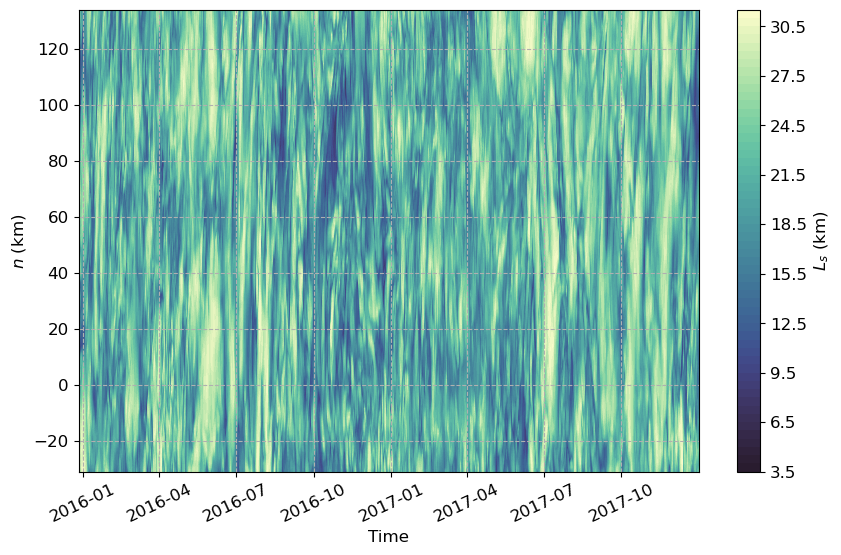

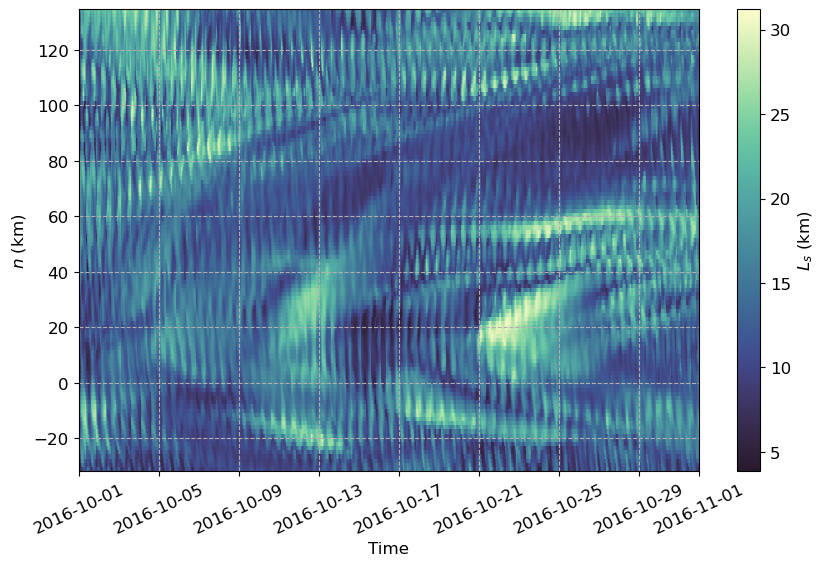

In [11]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(time_dt, n_coord, delta_s.T, cmap=cmocean.cm.deep_r,levels=60)

# Set figure attributes
plt.xlabel('Time')
plt.ylabel(r'$n$ (km)')
plt.xticks(rotation=25)
plt.colorbar(label=r'$L_s$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

#--- Zoom in on a single event ---# 

# Define start and end datetimes
start_time = datetime(2016, 10, 1, 0, 0, 0) 
end_time = datetime(2016, 11, 1, 0, 0, 0)   

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.pcolormesh(time_dt, n_coord, delta_s.T, cmap=cmocean.cm.deep_r,shading='auto')
#plt.contourf(time_ds, n_ds, delta_s.T, cmap='RdYlBu_r',levels=100)

# Set figure attributes
plt.xlabel('Time')
plt.ylabel(r'$n$ (km)')
plt.xlim((start_time,end_time))
#plt.ylim((40,80))
plt.xticks(rotation=25)
plt.colorbar(label=r'$L_s$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()


In [35]:
from scipy.ndimage import gaussian_filter

Ls = delta_s

start_time = datetime(2016, 10, 1, 0, 0, 0)  # Specifies the start time of the event period
end_time = datetime(2016, 11, 1, 0, 0, 0)    # Specifies the end time of the event period
event_time_bnds = [start_time, end_time]

# Grab data from the event time period
idx_time = (time_dt >= event_time_bnds[0]) & (time_dt <= event_time_bnds[1])
time_scale_event = time_dt[idx_time]
Ls_event = Ls[idx_time,:]

Ls_smoothed = gaussian_filter(Ls_event, sigma=(5, 1))

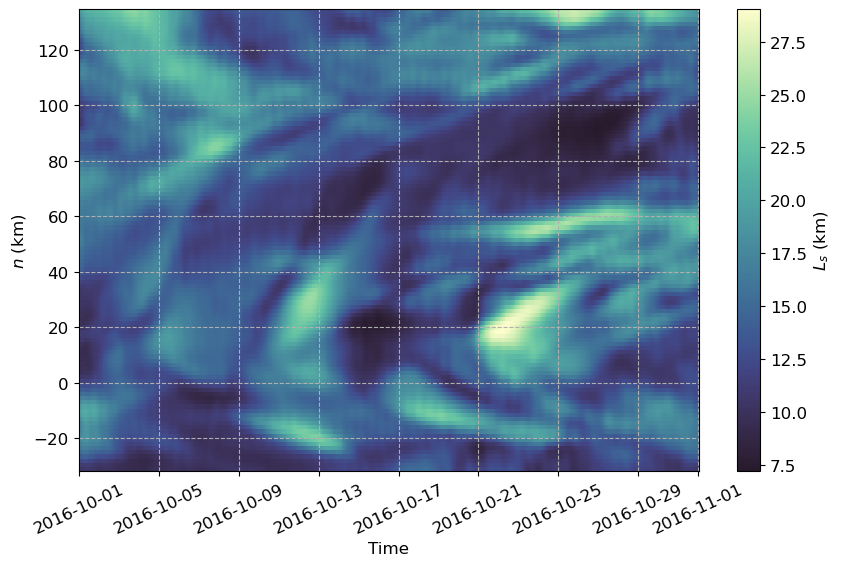

In [36]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.pcolormesh(time_scale_event, n_coord, Ls_smoothed.T, cmap=cmocean.cm.deep_r,shading='auto')
#plt.contourf(time_ds, n_ds, delta_s.T, cmap='RdYlBu_r',levels=100)

# Set figure attributes
plt.xlabel('Time')
plt.ylabel(r'$n$ (km)')
#plt.ylim((40,80))
plt.xticks(rotation=25)
plt.colorbar(label=r'$L_s$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

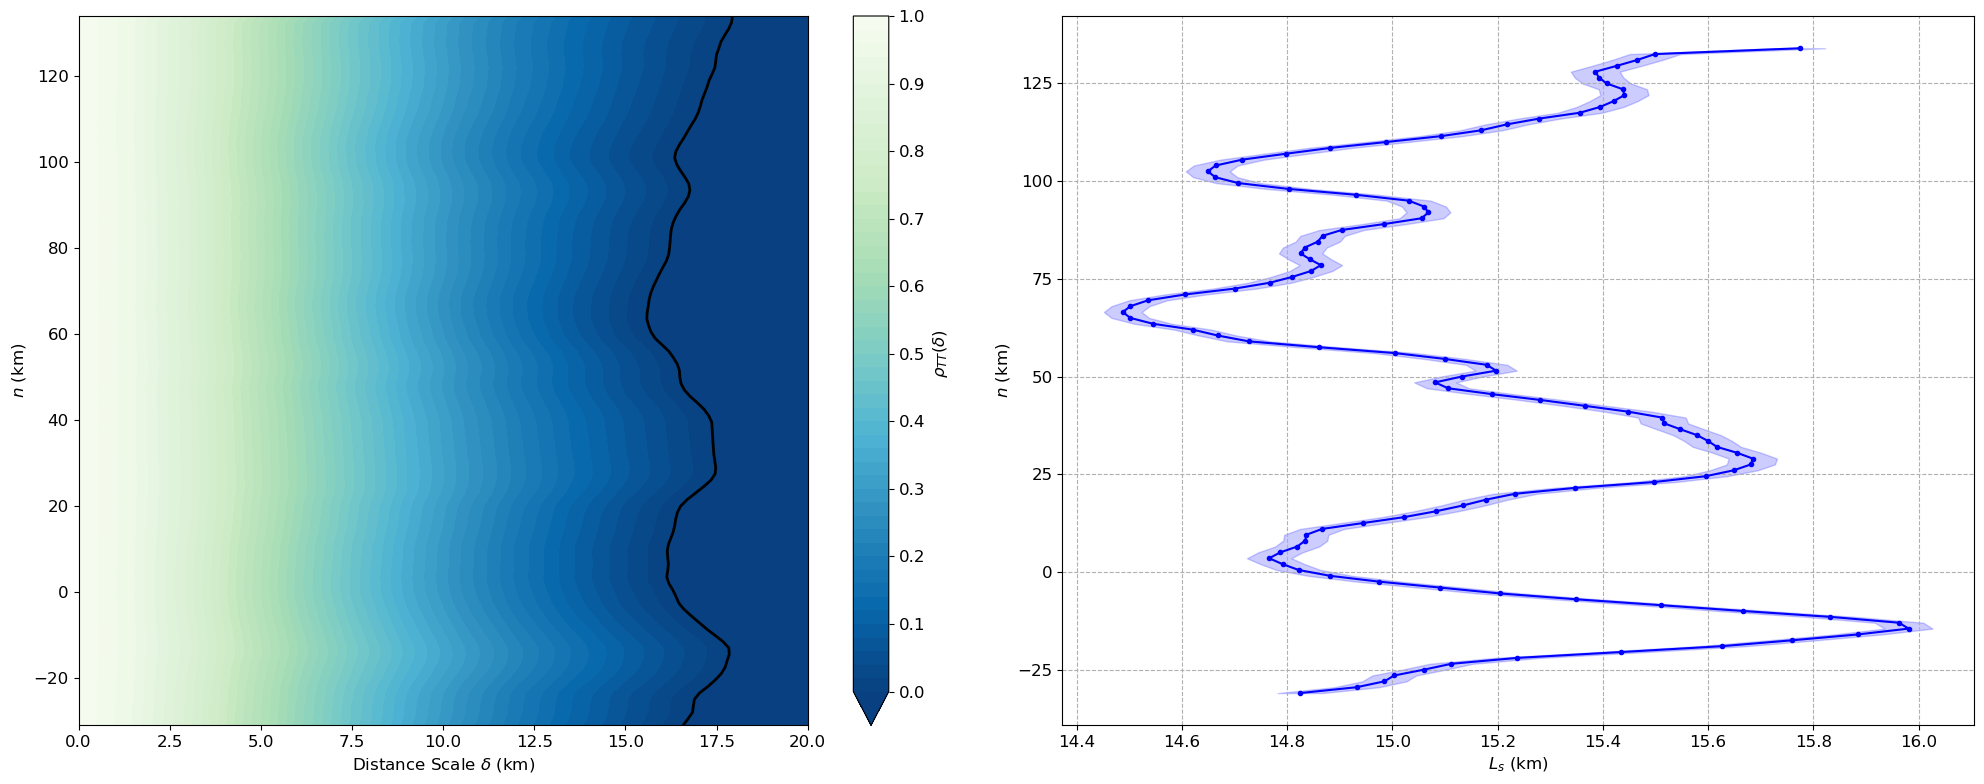

In [34]:
# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$\rho_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$\rho_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Create figure
fig = plt.figure(figsize=(10, 6))

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(0,1+0.02,0.02)

# Create the figure
fig = plt.figure(figsize=(20, 8))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(121)

# Create meshgrid and zeros surface 
N_coord, D = np.meshgrid(n_coord,dist_scale_mtime[:,1])  

# Plot the time averaged autocorrelation function 
contour = ax1.contourf(D, N_coord, autocorr_mtime, cmap = cmap, levels=levels,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(D,N_coord,autocorr_mtime, levels=[0], colors='black', linewidths=2)

# Set figure attributes
#ax1.set_title(r'Along-isobath decorrelation $L_s(n,t)$')
ax1.set_xlabel(r'Distance Scale $\delta$ (km)')
ax1.set_ylabel(r'$n$ (km)')
ax1.set_yticks(np.arange(-20,120+20,20))
ax1.set_xlim(0,20)

# Set color bar
#cbar_ax = fig.add_axes([0.91, 0.55, 0.02, 0.35])  # adjust position as needed
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

#--- Subplot #2 ---# 
ax2 = fig.add_subplot(122)

# Plot the decorrelation scale
ax2.plot(delta_s_mt, n_coord, 'b.-')

# Plot the error bars of the mean autocorrelation function 
ax2.fill_betweenx(n_coord, delta_s_mt - delta_s_stdmt,delta_s_mt + delta_s_stdmt,color='b',alpha=0.2)

# Set figure attributes
ax2.set_xlabel(r'$L_s$ (km)')
ax2.set_ylabel(r'$n$ (km)')
ax2.grid(True,linestyle='--')

# Show the plot
fig.tight_layout()
plt.show()

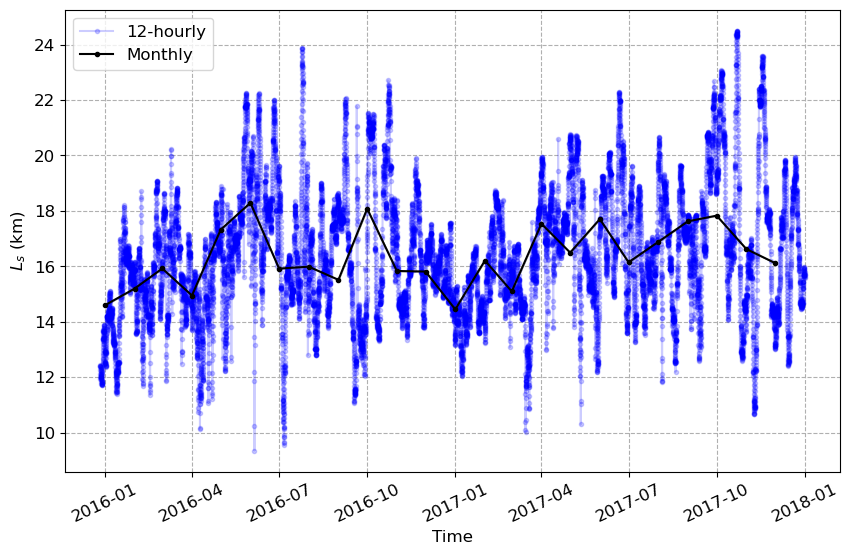

In [ ]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot the time averaged delta_s
plt.plot(time_dt,delta_s_mn, 'b.-',alpha=0.2,label='12-hourly')
plt.plot(unique_month_dates[1:],delta_monthly_m, 'k.-', label='Monthly')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(unique_month_dates[1:],delta_monthly_m - delta_monthly_stdm,delta_monthly_m + delta_monthly_stdm,color='k',alpha=0.2)

# Set figure attributes
plt.xlabel(r'Time')
plt.ylabel(r'$L_s$ (km)')
plt.grid(True,linestyle='--')
plt.xticks(rotation=25)
plt.legend(loc='upper left')
#plt.xlim(time_ds[0],time_ds[200])
#plt.ylim(10,18)

# Show the plot
plt.show()

### Approach 2: Across-isobath decorrelation $\delta_n(s,t)$

In [37]:
# Set parameters
ntime,nS,nN = np.shape(data)              # Dimensions of the data array 
lag = nN                                  # Number of lagged steps for the autocorrelation function 

# Initialize arrays 
autocorr_ts = np.zeros((ntime,nS,nN))
length_scale_ts = np.zeros((ntime,nS,nN))
delta_n = np.zeros((ntime,nS))
cn_time = 0 

# Loop through time 
for itime in range(0,ntime): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set along-isobath counter  
    cn_s = 0

    # Loop through s-coordinate 
    for is_coord in range(0,nS): 

        # Obtain the n-coordinate record at the ith time step and jth s-coordinate 
        data_s = data_m[itime,is_coord,:]

        # Detrend data record 
        data_dt = detrend(data_s, n_coord, mean = 0)

        # Compute autocorrelation function
        autocorr_ts[cn_time,cn_s,:], _, _, _, length_scale_ts[cn_time,cn_s,:], _ = compute_autocorr(data_dt, n_coord, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_n[cn_time,cn_s] = compute_decor_scale(autocorr_ts[cn_time,cn_s,:],length_scale_ts[cn_time,cn_s,:],L,estimator,0)

        # Set latitude counter
        cn_s += 1

    # Set cross-isobath counter
    cn_time += 1

Progress: 100.0%

In [38]:
# Average in time and n-coordinate respectively
autocorr_mtime = np.mean(autocorr_ts,axis=0)
autocorr_ms = np.mean(autocorr_ts,axis=1)
dist_scale_mtime = np.mean(length_scale_ts,axis=0)
dist_scale_ms = np.mean(length_scale_ts,axis=1)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_stdmtime = np.std(autocorr_ts,axis=0,ddof=1)/np.sqrt(autocorr_ts.shape[0])
autocorr_stdms = np.std(autocorr_ts,axis=1,ddof=1)/np.sqrt(autocorr_ts.shape[1])

#--- Time ---# 

# Initialize arrays
delta_n_mt    = np.zeros((len(s_coord)))
delta_n_stdmt = np.zeros((len(s_coord)))

# Loop through s-coordinate
for iS in range(0,len(s_coord)):

    # Compute the along-isobath decorrelation scale
    delta_n_mt[iS]  = compute_decor_scale(autocorr_mtime[iS,:],dist_scale_mtime[iS,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_n_ustd = compute_decor_scale(autocorr_mtime[iS,:] + autocorr_stdmtime[iS,:] ,dist_scale_mtime[iS,:] ,L,estimator,0)
    delta_n_lstd = compute_decor_scale(autocorr_mtime[iS,:] - autocorr_stdmtime[iS,:] ,dist_scale_mtime[iS,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_n_ustd - delta_n_mt[iS]
    std_lower = abs(delta_n_lstd - delta_n_mt[iS])
    delta_n_stdmt[iS]  = np.mean([std_upper, std_lower])

#--- s-coordinate ---# 

# Initialize arrays
delta_n_ms    = np.zeros((len(time_dt)))
delta_n_stdms = np.zeros((len(time_dt)))

# Loop through n-coordinate
for itime in range(0,len(time_dt)):

    # Compute the along-isobath decorrelation scale
    delta_n_ms[itime]  = compute_decor_scale(autocorr_ms[itime,:],dist_scale_ms[itime,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_n_ustd = compute_decor_scale(autocorr_ms[itime,:] + autocorr_stdms[itime,:] ,dist_scale_ms[itime,:] ,L,estimator,0)
    delta_n_lstd = compute_decor_scale(autocorr_ms[itime,:] - autocorr_stdms[itime,:] ,dist_scale_ms[itime,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_n_ustd - delta_n_ms[itime]
    std_lower = abs(delta_n_lstd - delta_n_ms[itime])
    delta_n_stdms[itime]  = np.mean([std_upper, std_lower])

Compute monthly averages to look for seasonality in the along-isobath decorrelation scale

In [39]:
# Initialize array 
autocorr_monthly_m    = np.zeros((num_unique_months-1,lag))
autocorr_monthly_stdm = np.zeros((num_unique_months-1,lag))
dist_scale_monthly_m  = np.zeros((num_unique_months-1,lag))
delta_monthly_m       = np.zeros((num_unique_months-1))
delta_monthly_stdm    = np.zeros((num_unique_months-1))

# Set counter
cn_month = 0

# Loop through years
for y in range(2016,2018): 

    # Find the indicies for the ith month
    ind_y = years == y

    # Loop through months
    for m in unique_months:

        # Find the indicies for the ith month
        ind_m = months == m

        # Combine indices 
        ind = np.logical_and(ind_y,ind_m)

        # Average in time and n-coordinate 
        autocorr_monthly_m[cn_month,:] = np.mean(autocorr_ts[ind,:,:], axis=(0,1))
        dist_scale_monthly_m[cn_month,:] = np.mean(length_scale_ts, axis=(0,1))

        # Compute the standard error of the mean in time and n-coordinate
        autocorr_monthly_stdm[cn_month,:] = np.std(autocorr_ts[ind,:,:], axis=(0,1), ddof=1)/np.sqrt(autocorr_ts[ind,:,:].size)

        # Compute the ith monthly mean decorrelation scale
        delta_monthly_m[cn_month] = compute_decor_scale(autocorr_monthly_m[cn_month,:],dist_scale_monthly_m[cn_month,:],L,estimator,0)

        # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
        delta_n_ustd = compute_decor_scale(autocorr_monthly_m[cn_month,:] + autocorr_monthly_stdm[cn_month,:] ,dist_scale_monthly_m[cn_month,:] ,L,estimator,0)
        delta_n_lstd = compute_decor_scale(autocorr_monthly_m[cn_month,:] - autocorr_monthly_stdm[cn_month,:] ,dist_scale_monthly_m[cn_month,:] ,L,estimator,0)

        # Compute the average standard error 
        std_upper = delta_n_ustd - delta_monthly_m[cn_month]
        std_lower = abs(delta_n_lstd - delta_monthly_m[cn_month])
        delta_monthly_stdm[cn_month]  = np.mean([std_upper, std_lower])

        # Reinitialize month counter 
        cn_month += 1

Save decorrelation scale 

In [47]:
# Check if file exists, then delete it
file_path = PATH + "/mitgcm_cross_isobath_decorr_scale_" + option_var  + "_depth_99.0m.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Cross-isobath decorrelation length scale from the coordinate transformed MIT gcm model out of ' + option_var + '.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        delta_n         = delta_n,
        delta_n_mt      = delta_n_mt,
        delta_n_stdmt    = delta_n_stdmt,
        delta_n_ms      = delta_n_ms,
        delta_n_stdms   = delta_n_stdms,
        n               = s_coord,
        time            = time_dt,
        metadata        = metadata
        )

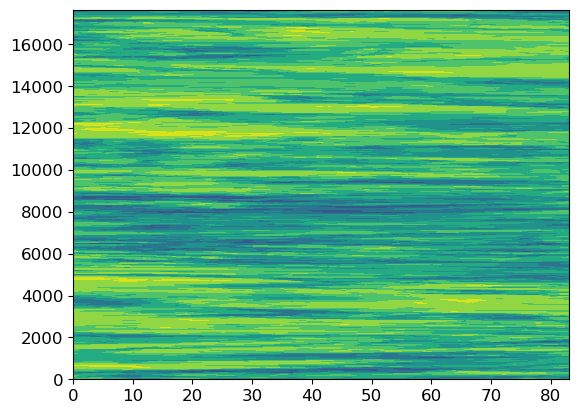

In [46]:
plt.contourf(delta_n) 
plt.show()

Plot cross-isobath decorrelation scales

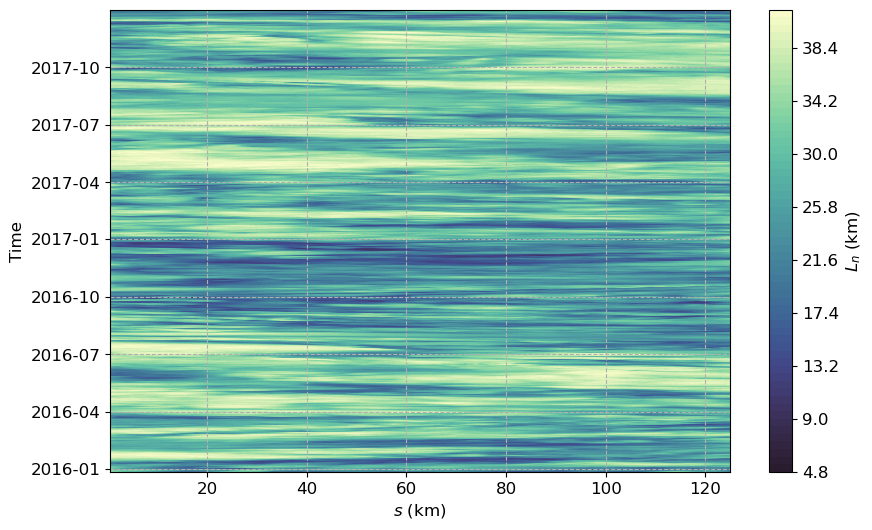

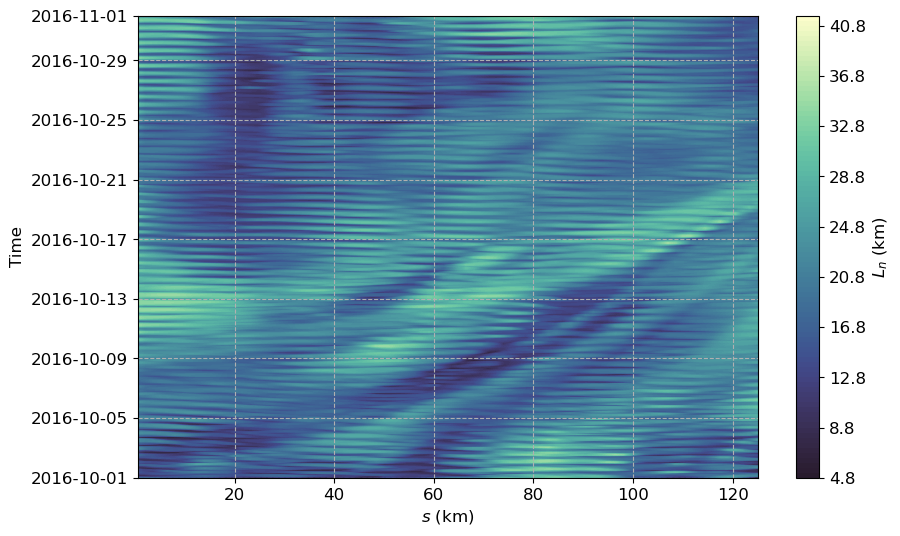

In [41]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord,time_dt, delta_n, cmap=cmocean.cm.deep_r,levels=60)

# Set figure attributes
plt.xlabel(r'$s$ (km)')
plt.ylabel('Time')
plt.colorbar(label=r'$L_n$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

#--- Zoom in on a single event ---# 

# Define start and end datetimes
start_time = datetime(2016, 10, 1, 0, 0, 0) 
end_time = datetime(2016, 11, 1, 0, 0, 0)   

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord, time_dt, delta_n, cmap=cmocean.cm.deep_r,levels=100)

# Set figure attributes
plt.xlabel(r'$s$ (km)')
plt.ylabel('Time')
plt.ylim((start_time,end_time))
plt.colorbar(label=r'$L_n$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_954/505846141.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1000x600 with 0 Axes>

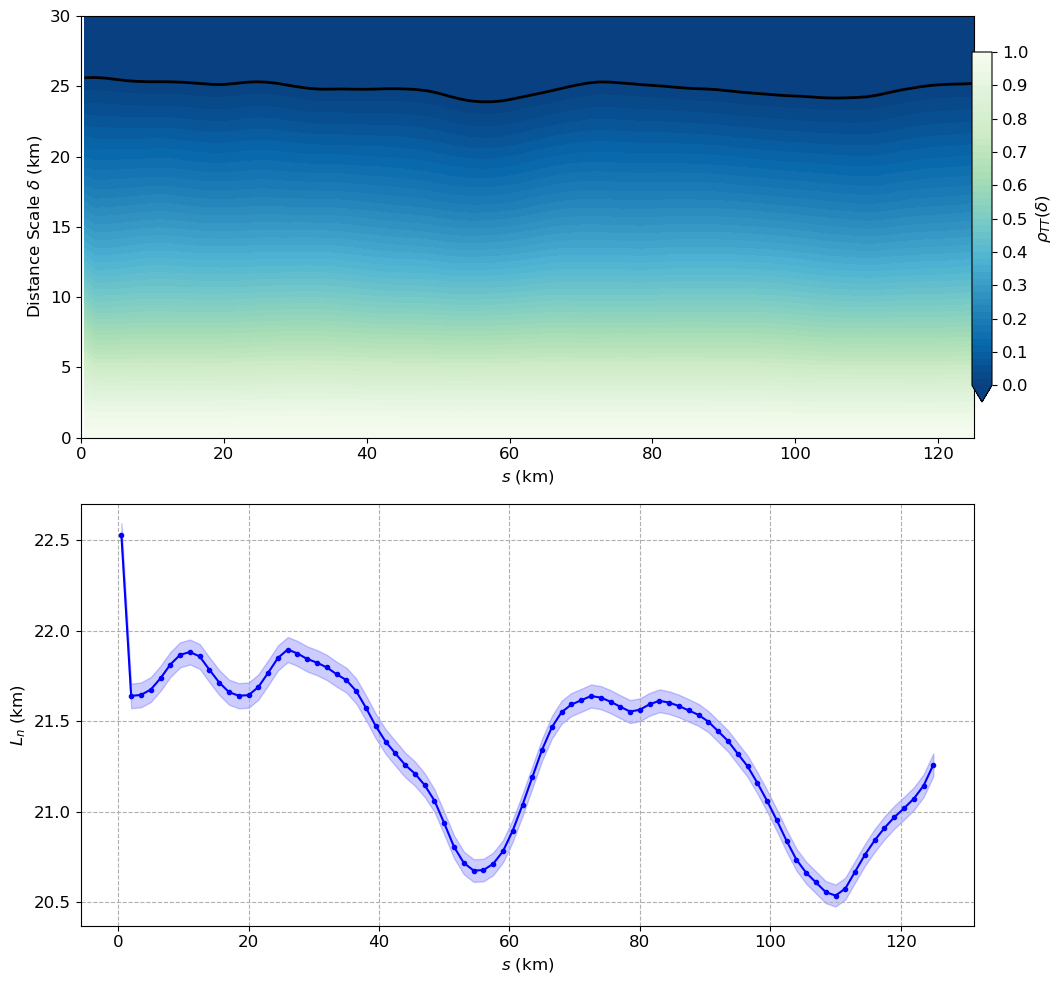

In [42]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(0,1+0.02,0.02)

# Create the figure
fig = plt.figure(figsize=(10, 10))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(211)

# Create meshgrid and zeros surface 
S_coord, D = np.meshgrid(s_coord,dist_scale_mtime[0,:])  

# Plot the time averaged autocorrelation function 
contour = ax1.contourf(S_coord, D, autocorr_mtime.T, cmap = cmap, levels=levels,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(S_coord,D,autocorr_mtime.T, levels=[0], colors='black', linewidths=2)

# Set figure attributes
#ax1.set_title(r'Along-isobath decorrelation $L_s(n,t)$')
ax1.set_xlabel(r'$s$ (km)')
ax1.set_ylabel(r'Distance Scale $\delta$ (km)')
ax1.set_xticks(np.arange(0,120+20,20))
ax1.set_ylim(0,30)

# Set color bar
cbar_ax = fig.add_axes([0.98, 0.59, 0.02, 0.35])  # adjust position as needed
cbar = fig.colorbar(contour,cax = cbar_ax, extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

#--- Subplot #2 ---# 
ax2 = fig.add_subplot(212)

# Plot the decorrelation scale
ax2.plot(s_coord, delta_n_mt, 'b.-')

# Plot the error bars of the mean autocorrelation function 
ax2.fill_between(s_coord, delta_n_mt - delta_n_stdmt,delta_n_mt + delta_n_stdmt,color='b',alpha=0.2)

# Set figure attributes
ax2.set_xlabel(r'$s$ (km)')
ax2.set_ylabel(r'$L_n$ (km)')
ax2.grid(True,linestyle='--')

# Show the plot
fig.tight_layout()
plt.show()

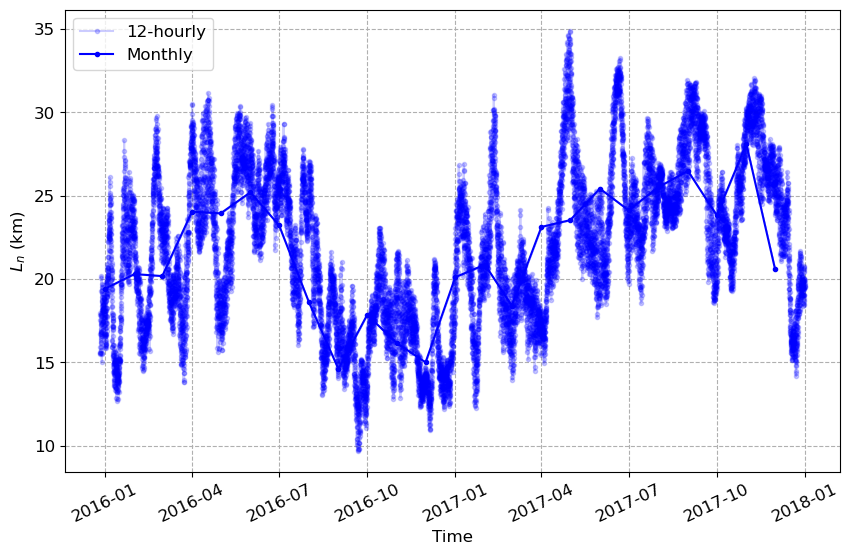

In [43]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot the time averaged delta_s
plt.plot(time_dt,delta_n_ms, 'b.-',alpha=0.2,label='12-hourly')
plt.plot(unique_month_dates[1:],delta_monthly_m, 'b.-', label='Monthly')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(unique_month_dates[1:],delta_monthly_m - delta_monthly_stdm,delta_monthly_m + delta_monthly_stdm,color='b',alpha=0.2)

# Set figure attributes
plt.xlabel(r'Time')
plt.ylabel(r'$L_n$ (km)')
plt.grid(True,linestyle='--')
plt.xticks(rotation=25)
plt.legend(loc='upper left')

# Show the plot
plt.show()

### Approach 3: Across-isobath decorrelation $\delta_n(s,t)$ for each regime

The regimes are defined in terms of distance from the 2000 meter isobath as:

1. Off-shelf: $n > 0$ 
2. On-shelf: $n < 0$
3. Shelf-break: $-10 < n < 10$

Alternatively, I could also define these regimes using the water depth (to be consistent with the reigme definitions from the spray glider analysis). With these definitions, we have 130, 30, 20 km spatial records for the off-shelf, on-shelf, and shelf-break regimes respectively. If I had more data onshelf (by decreasing the along-isobath coordinate and extending the n-coordinate), I would define the regimes as: 

1. Off-shelf: $n > 10$ 
2. On-shelf: $n < -10$
3. Shelf-break: $-10 < n < 10$

#### Off-shelf

In [10]:
# Define the regimes 
idx_off   = n_coord > 0
idx_trans = (n_coord >= -10) & (n_coord <= 10)
idx_on    = n_coord <= 0

# Set the data array for each regime
data_off   = data_m[:,:,idx_off]
data_trans = data_m[:,:,idx_trans]
data_on    = data_m[:,:,idx_on]

# Redefine the n-coordinate for each domain 
n_off   = n_coord[idx_off]
n_trans = n_coord[idx_trans]
n_on    = n_coord[idx_on]

#--- Off-shelf ---# 

# Set parameters
ntime,nS,nN = np.shape(data_off)          # Dimensions of the data array 
lag = nN                                  # Number of lagged steps for the autocorrelation function 

# Initialize arrays 
autocorr_off = np.zeros((ntime,nS,nN))
length_scale_off = np.zeros((ntime,nS,nN))
delta_off = np.zeros((ntime,nS))
cn_time = 0 

# Loop through time 
for itime in range(0,ntime): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set along-isobath counter  
    cn_s = 0

    # Loop through s-coordinate 
    for is_coord in range(0,nS): 

        # Obtain the n-coordinate record at the ith time step and jth s-coordinate 
        data_s = data_off[itime,is_coord,:]

        # Detrend data record 
        data_dt = detrend(data_s, n_off, mean = 0)

        # Compute autocorrelation function
        autocorr_off[cn_time,cn_s,:], _, _, _, length_scale_off[cn_time,cn_s,:], _ = compute_autocorr(data_dt, n_off, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_off[cn_time,cn_s] = compute_decor_scale(autocorr_off[cn_time,cn_s,:],length_scale_off[cn_time,cn_s,:],L,estimator,0)

        # Set latitude counter
        cn_s += 1

    # Set cross-isobath counter
    cn_time += 1

# Average in time and n-coordinate respectively
autocorr_off_m = np.mean(autocorr_off,axis=0)
dist_scale_off = np.mean(length_scale_off,axis=0)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_off_stdm = np.std(autocorr_off,axis=0,ddof=1)/np.sqrt(autocorr_off.shape[0])

#--- Time ---# 

# Initialize arrays
delta_off_m    = np.zeros((len(s_coord)))
delta_off_stdm = np.zeros((len(s_coord)))

# Loop through s-coordinate
for iS in range(0,len(s_coord)):

    # Compute the along-isobath decorrelation scale
    delta_off_m[iS]  = compute_decor_scale(autocorr_off_m[iS,:],dist_scale_off[iS,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_off_ustd = compute_decor_scale(autocorr_off_m[iS,:] + autocorr_off_stdm[iS,:] ,dist_scale_off[iS,:] ,L,estimator,0)
    delta_off_lstd = compute_decor_scale(autocorr_off_m[iS,:] - autocorr_off_stdm[iS,:] ,dist_scale_off[iS,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_off_ustd - delta_off_m[iS]
    std_lower = abs(delta_off_lstd - delta_off_m[iS])
    delta_off_stdm[iS]  = np.mean([std_upper, std_lower])

Progress: 100.0%

#### Shelf-Break

In [11]:
#--- Shelf-break ---# 

# Set parameters
ntime,nS,nN = np.shape(data_trans)          # Dimensions of the data array 
lag = nN                                  # Number of lagged steps for the autocorrelation function 

# Initialize arrays 
autocorr_trans = np.zeros((ntime,nS,nN))
length_scale_trans = np.zeros((ntime,nS,nN))
delta_trans = np.zeros((ntime,nS))
cn_time = 0 

# Loop through time 
for itime in range(0,ntime): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set along-isobath counter  
    cn_s = 0

    # Loop through s-coordinate 
    for is_coord in range(0,nS): 

        # Obtain the n-coordinate record at the ith time step and jth s-coordinate 
        data_s = data_trans[itime,is_coord,:]

        # Detrend data record 
        data_dt = detrend(data_s, n_trans, mean = 0)

        # Compute autocorrelation function
        autocorr_trans[cn_time,cn_s,:], _, _, _, length_scale_trans[cn_time,cn_s,:], _ = compute_autocorr(data_dt, n_trans, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_trans[cn_time,cn_s] = compute_decor_scale(autocorr_trans[cn_time,cn_s,:],length_scale_trans[cn_time,cn_s,:],L,estimator,0)

        # Set latitude counter
        cn_s += 1

    # Set cross-isobath counter
    cn_time += 1

# Average in time and n-coordinate respectively
autocorr_trans_m = np.mean(autocorr_trans,axis=0)
dist_scale_trans = np.mean(length_scale_trans,axis=0)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_trans_stdm = np.std(autocorr_trans,axis=0,ddof=1)/np.sqrt(autocorr_trans.shape[0])

#--- Time ---# 

# Initialize arrays
delta_trans_m    = np.zeros((len(s_coord)))
delta_trans_stdm = np.zeros((len(s_coord)))

# Loop through s-coordinate
for iS in range(0,len(s_coord)):

    # Compute the along-isobath decorrelation scale
    delta_trans_m[iS]  = compute_decor_scale(autocorr_trans_m[iS,:],dist_scale_trans[iS,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_trans_ustd = compute_decor_scale(autocorr_trans_m[iS,:] + autocorr_trans_stdm[iS,:] ,dist_scale_trans[iS,:] ,L,estimator,0)
    delta_trans_lstd = compute_decor_scale(autocorr_trans_m[iS,:] - autocorr_trans_stdm[iS,:] ,dist_scale_trans[iS,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_trans_ustd - delta_trans_m[iS]
    std_lower = abs(delta_trans_lstd - delta_trans_m[iS])
    delta_trans_stdm[iS]  = np.mean([std_upper, std_lower])


Progress: 100.0%

#### On-shelf

In [12]:
#--- On-shelf ---# 

# Set parameters
ntime,nS,nN = np.shape(data_on)          # Dimensions of the data array 
lag = nN                                  # Number of lagged steps for the autocorrelation function 

# Initialize arrays 
autocorr_on = np.zeros((ntime,nS,nN))
length_scale_on = np.zeros((ntime,nS,nN))
delta_on = np.zeros((ntime,nS))
cn_time = 0 

# Loop through time 
for itime in range(0,ntime): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set along-isobath counter  
    cn_s = 0

    # Loop through s-coordinate 
    for is_coord in range(0,nS): 

        # Obtain the n-coordinate record at the ith time step and jth s-coordinate 
        data_s = data_on[itime,is_coord,:]

        # Detrend data record 
        data_dt = detrend(data_s, n_on, mean = 0)

        # Compute autocorrelation function
        autocorr_on[cn_time,cn_s,:], _, _, _, length_scale_on[cn_time,cn_s,:], _ = compute_autocorr(data_dt, n_on, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_on[cn_time,cn_s] = compute_decor_scale(autocorr_on[cn_time,cn_s,:],length_scale_on[cn_time,cn_s,:],L,estimator,0)

        # Set latitude counter
        cn_s += 1

    # Set cross-isobath counter
    cn_time += 1

# Average in time and n-coordinate respectively
autocorr_on_m = np.mean(autocorr_on,axis=0)
dist_scale_on = np.mean(length_scale_on,axis=0)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_on_stdm = np.std(autocorr_on,axis=0,ddof=1)/np.sqrt(autocorr_on.shape[0])

#--- Time ---# 

# Initialize arrays
delta_on_m    = np.zeros((len(s_coord)))
delta_on_stdm = np.zeros((len(s_coord)))

# Loop through s-coordinate
for iS in range(0,len(s_coord)):

    # Compute the along-isobath decorrelation scale
    delta_on_m[iS]  = compute_decor_scale(autocorr_on_m[iS,:],dist_scale_on[iS,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_on_ustd = compute_decor_scale(autocorr_on_m[iS,:] + autocorr_on_stdm[iS,:] ,dist_scale_on[iS,:] ,L,estimator,0)
    delta_on_lstd = compute_decor_scale(autocorr_on_m[iS,:] - autocorr_on_stdm[iS,:] ,dist_scale_on[iS,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_on_ustd - delta_on_m[iS]
    std_lower = abs(delta_on_lstd - delta_on_m[iS])
    delta_on_stdm[iS]  = np.mean([std_upper, std_lower])

Progress: 100.0%

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_9868/1314171362.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_9868/1314171362.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])


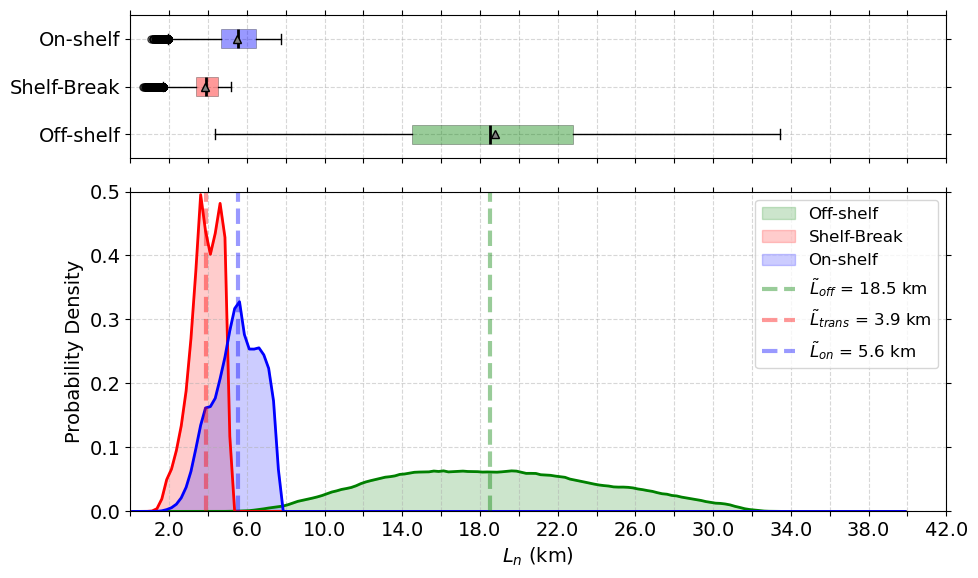

In [76]:
import stats
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set bin width and edges
bin_width = 0.25
bin_edges = np.arange(0,40+bin_width,bin_width)

# Compute histograms 
_, pdf_off, bin_centers_off = stats.compute_pdf_1D(delta_off.flatten(),bin_edges)
_, pdf_trans, bin_centers_trans = stats.compute_pdf_1D(delta_trans.flatten(),bin_edges)
_, pdf_on, bin_centers_on = stats.compute_pdf_1D(delta_on.flatten(),bin_edges)

L_off_median   = np.median(delta_off)
L_trans_median = np.median(delta_trans)
L_on_median    = np.median(delta_on)

# Create figure
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3 rows, 1 column

# Set axes
ax1 = fig.add_subplot(gs[0])       # Top subplot
ax2 = fig.add_subplot(gs[1:])      # Bottom subplot spans rows 2 and 3

#--- Subplot 1 ---# 

bp = ax1.boxplot([delta_off.flatten(), delta_trans.flatten(), delta_on.flatten()],vert=False, patch_artist=True, widths=0.4, showmeans=True,
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='-',linewidth=2,color='k'), 
            boxprops=dict(color='k',          # Edge color
                          facecolor='blue',
                          linewidth=0.5,           # Border thickness
                          linestyle='-',
                          alpha=0.4), 
            whiskerprops=dict(linewidth=1, 
                              color= 'k', 
                              linestyle='-'), 
            meanprops=dict(color='gray',
                           markerfacecolor='gray',
                           markeredgecolor='k',
                           linewidth='0.5'
            ))

# Change individual box colors
colors = ['green', 'red', 'blue']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

# Set figure attributes
ax1.set_xlim((0,42))
ax1.xaxis.set_major_locator(MultipleLocator(2))
xticks = ax1.get_xticks()
ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([r'Off-shelf', r'Shelf-Break', r'On-shelf'])

#--- Subplot 2 ---# 

# Plot histogram
ax2.plot(bin_centers_off, pdf_off,'-',color='green',linewidth=2)
ax2.plot(bin_centers_trans, pdf_trans,'-',color='red',linewidth=2)
ax2.plot(bin_centers_on, pdf_on,'-',color='blue',linewidth=2)
ax2.fill_between(bin_centers_off, pdf_off, color='green', alpha=0.2, label='Off-shelf')
ax2.fill_between(bin_centers_trans, pdf_trans, color='red', alpha=0.2, label='Shelf-Break')
ax2.fill_between(bin_centers_on, pdf_on, color='blue', alpha=0.2, label='On-shelf')

# Plot statistics
ax2.axvline(L_off_median,color='green',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{off}$ = ' + str(np.round(L_off_median,1)) + ' km')
ax2.axvline(L_trans_median,color='red',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{trans}$ = ' + str(np.round(L_trans_median,1)) + ' km')
ax2.axvline(L_on_median,color='blue',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{on}$ = ' + str(np.round(L_on_median,1)) + ' km')

# Set figure attributes
ax2.set_xlabel(r'$L_n$ (km)')
ax2.set_ylabel('Probability Density')
ax2.set_xlim((0,42))
ax2.set_ylim((0,0.5))
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
xticks = ax2.get_xticks()
ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=fontsize-2)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

plt.tight_layout()
plt.show()

Plot the temporal and spatial decorrelation scale for each regime 

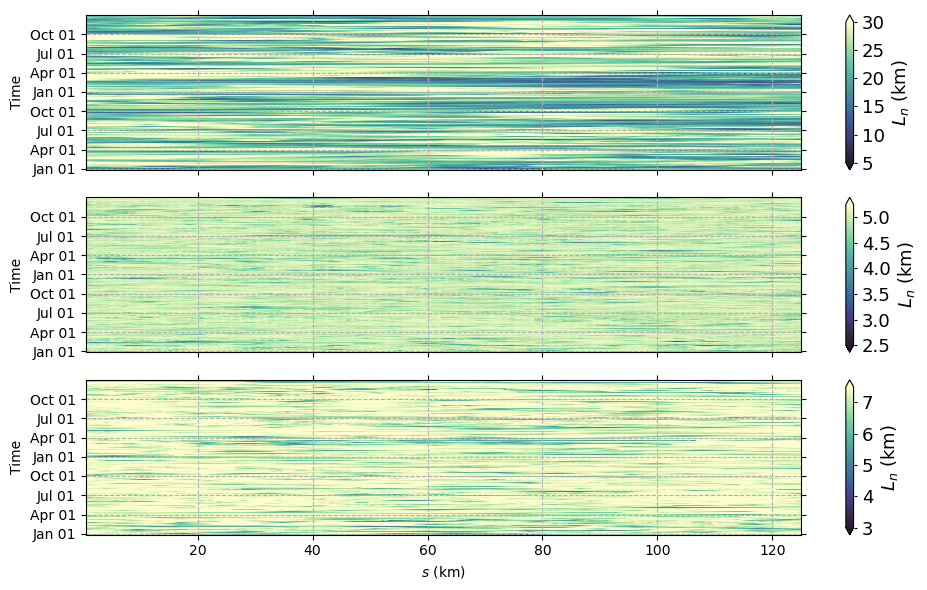

In [73]:
# Set plotting parameters
fontsize = 14

# Create figure
fig, axes = plt.subplots(3,1, figsize=(10, 6))

# Common color limits
#vmin, vmax = 0, 10
#levels = np.linspace(vmin, vmax, 60)

#--- Subplot 1 ---# 
ax1 = axes[0]
levels = np.arange(5,30+0.5,0.5)

# Plot off-shelf regime
mesh = ax1.contourf(s_coord, time_dt, delta_off, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax1.set_ylabel('Time')
ax1.grid(True,linestyle='--')
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax1.set_xticklabels([])

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

#--- Subplot 2 ---# 
ax2 = axes[1]
levels = np.arange(2.5,5.25+0.05,0.05)

# Plot shelf-break regime
mesh = ax2.contourf(s_coord, time_dt, delta_trans, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax2.set_ylabel('Time')
ax2.grid(True,linestyle='--')
ax2.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.set_xticklabels([])

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(2.5, 5.25, 0.5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

#--- Subplot 3 ---# 
ax3 = axes[2]
levels = np.arange(3,7.5+0.05,0.05)

# Plot On-shelf regime
mesh = ax3.contourf(s_coord, time_dt, delta_on, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax3.set_xlabel(r'$s$ (km)')
ax3.set_ylabel('Time')
ax3.grid(True,linestyle='--')
ax3.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(3, 7.5, 1))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.tight_layout()
plt.show()

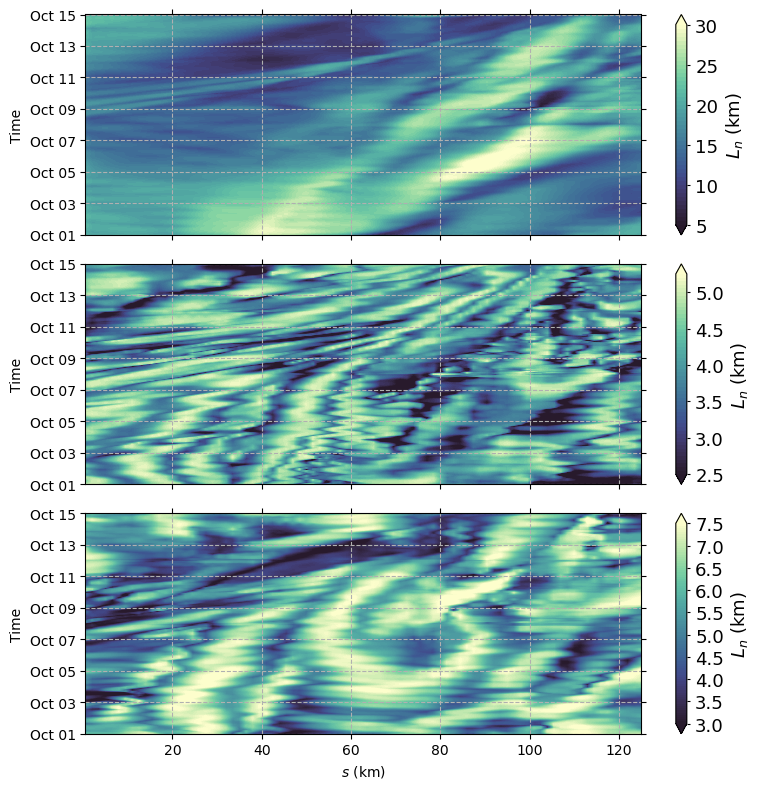

In [ ]:
# Set plotting parameters
start_time = datetime(2016, 10, 1, 0, 0, 0) 
end_time = datetime(2016, 10, 15, 0, 0, 0)  

# Create figure
fig, axes = plt.subplots(3,1, figsize=(8, 8))

#--- Subplot 1 ---# 
ax1 = axes[0]
levels = np.arange(5,30+0.5,0.5)

# Plot off-shelf regime
mesh = ax1.contourf(s_coord, time_dt, delta_off, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax1.set_ylabel('Time')
ax1.set_ylim((start_time,end_time))
ax1.grid(True,linestyle='--')
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax1.set_xticklabels([])

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

#--- Subplot 2 ---# 
ax2 = axes[1]
levels = np.arange(2.5,5.25+0.05,0.05)

# Plot shelf-break regime
mesh = ax2.contourf(s_coord, time_dt, delta_trans, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax2.set_ylabel('Time')
ax2.set_ylim((start_time,end_time))
ax2.grid(True,linestyle='--')
ax2.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.set_xticklabels([])

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(2.5, 5.25, 0.5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

#--- Subplot 3 ---# 
ax3 = axes[2]
levels = np.arange(3,7.5+0.05,0.05)

# Plot On-shelf regime
mesh = ax3.contourf(s_coord, time_dt, delta_on, cmap=cmocean.cm.deep_r, levels=levels,extend='both')

# Set figure attributes
ax3.set_xlabel(r'$s$ (km)')
ax3.set_ylabel('Time')
ax3.set_ylim((start_time,end_time))
ax3.grid(True,linestyle='--')
ax3.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical',extend='both')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(3, 7.5+0.5, 0.5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.tight_layout()
plt.show()

Plot the cross-isobath decorrelation scales for each regime

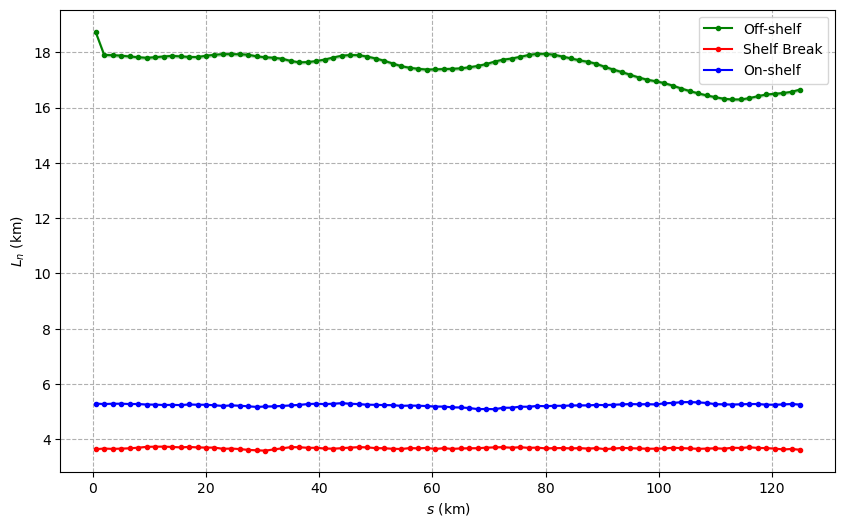

In [68]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot the time averaged delta_s
plt.plot(s_coord, delta_off_m, 'g.-', label='Off-shelf')
plt.plot(s_coord, delta_trans_m, 'r.-', label='Shelf Break')
plt.plot(s_coord, delta_on_m, 'b.-', label='On-shelf')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(s_coord, delta_off_m - delta_off_stdm, delta_off_m + delta_off_stdm,color='g',alpha=0.2)
plt.fill_between(s_coord, delta_trans_m - delta_trans_stdm, delta_trans_m + delta_trans_stdm,color='r',alpha=0.2)
plt.fill_between(s_coord, delta_on_m - delta_on_stdm, delta_on_m + delta_on_stdm,color='b',alpha=0.2)

# Set figure attributes
plt.legend()
plt.xlabel(r'$s$ (km)')
plt.ylabel(r'$L_n$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

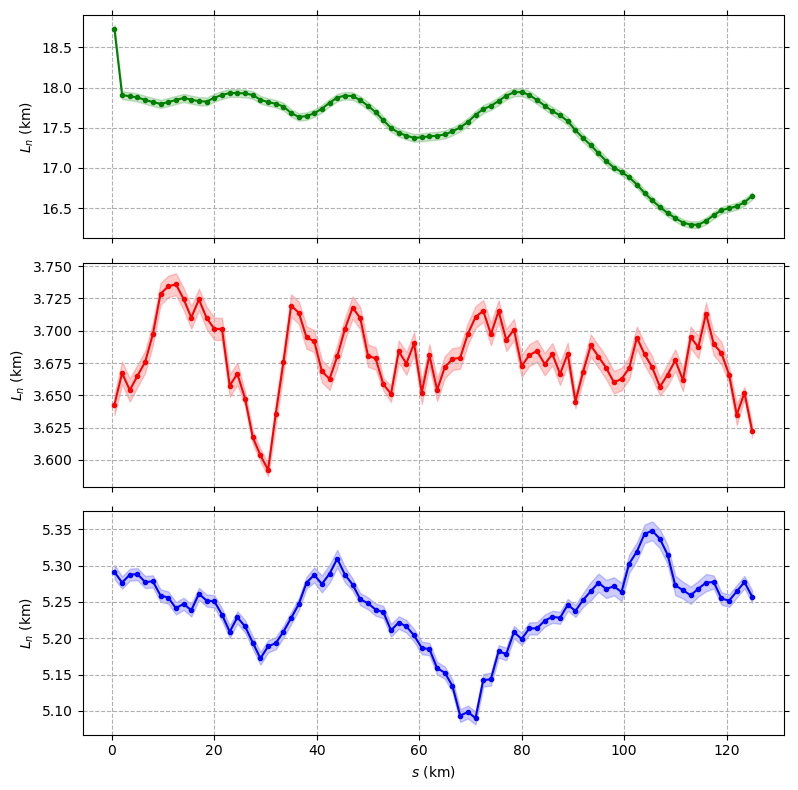

In [72]:
# Create figure
fig, axes = plt.subplots(3,1, figsize=(8, 8))

#--- Subplot 1 ---# 
ax1 = axes[0]

# Plot the time averaged delta_n
ax1.plot(s_coord, delta_off_m, 'g.-', label='Off-shelf')

# Plot the error bars 
ax1.fill_between(s_coord, delta_off_m - delta_off_stdm, delta_off_m + delta_off_stdm,color='g',alpha=0.2)

# Set figure attributes
ax1.set_ylabel(r'$L_n$ (km)')
ax1.grid(True,linestyle='--')
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax1.set_xticklabels([])

#--- Subplot 2 ---# 
ax2 = axes[1]

# Plot the time averaged delta_n
ax2.plot(s_coord, delta_trans_m, 'r.-', label='Shelf Break')

# Plot the error bars 
ax2.fill_between(s_coord, delta_trans_m - delta_trans_stdm, delta_trans_m + delta_trans_stdm,color='r',alpha=0.2)

# Set figure attributes
ax2.set_ylabel(r'$L_n$ (km)')
ax2.grid(True,linestyle='--')
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.set_xticklabels([])

#--- Subplot 3 ---# 
ax3 = axes[2]

# Plot the time averaged delta_n
ax3.plot(s_coord, delta_on_m, 'b.-', label='Off-shelf')

# Plot the error bars 
ax3.fill_between(s_coord, delta_on_m - delta_on_stdm, delta_on_m + delta_on_stdm,color='b',alpha=0.2)

# Set figure attributes
ax3.set_xlabel(r'$s$ (km)')
ax3.set_ylabel(r'$L_n$ (km)')
ax3.grid(True,linestyle='--')
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

# Show the plot
plt.tight_layout()
plt.show()

# Development Code

In [ ]:
# Set parameters used in all regions
incr_t = 12                               # Specifies the increment to skip over time steps to speed up the computation (hours)
incr_s = 4                                # Specifies the increment to skip over s-coordinate steps to speed up the computation (km)

# Redefine independent variables (time and s-coordinate)
time_ds = time_dt[:len(time_dt) - incr_t:incr_t]
s_ds = s_coord[:len(s_coord) - incr_s:incr_s]

In [ ]:
# Compute the along isobath decorrelation scale
delta_s[cn_time,cn_n] = compute_decor_scale(autocorr_tn[cn_time,:,cn_n],length_scale[cn_time,:,cn_n],L,estimator,0)

delta_s_tav = np.mean(delta_s,axis=0)
delta_s_tstdm = np.std(delta_s,axis=0,ddof=1)/np.sqrt(delta_s.shape[0])

delta_s_Nav = np.mean(delta_s,axis=1)
delta_s_Nstdm = np.std(delta_s,axis=1,ddof=1)/np.sqrt(delta_s.shape[1])

# Compute the ith monthly mean 
delta_monthly_m[cn_month] = np.mean(delta_s[ind,:])

# Compute the ith standard error of the mean
N = delta_s[ind,:].size
delta_monthly_stdm[cn_month] = np.std(delta_s[ind,:],ddof=1)/np.sqrt(N)

# Average in time and n-coordinate respectively
delta_n_tav = np.mean(delta_n,axis=0)
delta_n_tstdm = np.std(delta_n,axis=0,ddof=1)/np.sqrt(delta_n.shape[0])

delta_n_Sav = np.mean(delta_n,axis=1)
delta_n_Sstdm = np.std(delta_n,axis=1,ddof=1)/np.sqrt(delta_n.shape[1])

# Compute the ith monthly mean 
delta_monthly_m[cn_month] = np.mean(delta_n[ind,:])

# Compute the ith standard error of the mean
N = delta_s[ind,:].size
delta_monthly_stdm[cn_month] = np.std(delta_s[ind,:],ddof=1)/np.sqrt(N)

# Average in time and n-coordinate respectively
delta_off_tav = np.mean(delta_off,axis=0)
delta_off_tstdm = np.std(delta_off,axis=0,ddof=1)/np.sqrt(delta_off.shape[0])

delta_off_Sav = np.mean(delta_off,axis=1)
delta_off_Sstdm = np.std(delta_off,axis=1,ddof=1)/np.sqrt(delta_off.shape[1])

# Average in time and n-coordinate respectively
delta_trans_tav = np.mean(delta_trans,axis=0)
delta_trans_tstdm = np.std(delta_trans,axis=0,ddof=1)/np.sqrt(delta_trans.shape[0])

delta_trans_Sav = np.mean(delta_trans,axis=1)
delta_trans_Sstdm = np.std(delta_trans,axis=1,ddof=1)/np.sqrt(delta_trans.shape[1])

# Average in time and n-coordinate respectively
delta_on_tav = np.mean(delta_on,axis=0)
delta_on_tstdm = np.std(delta_on,axis=0,ddof=1)/np.sqrt(delta_on.shape[0])

delta_on_Sav = np.mean(delta_on,axis=1)
delta_on_Sstdm = np.std(delta_on,axis=1,ddof=1)/np.sqrt(delta_on.shape[1])

In [ ]:
# Set parameters
incr_t = 1                               # Specifies the increment to skip over time steps to speed up the computation
incr_n = 1                                # Specifies the increment to skip over n-coordinate steps to speed up the computation
ntime,nS,nN = np.shape(data)              # Dimensions of the data array 
lag = nS                                  # Number of lagged steps for the autocorrelation function 
ntime_s, nN_s = int(np.floor(ntime/incr_t)), int(np.floor(nN/incr_n)) # Redefine the number of time and n-coordinate length after setting the incrementation

# Redefine independent variables (time and n-coordinate)
time_ds = time_dt[:len(time_dt) - incr_t:incr_t]
n_ds = n_coord[:len(n_coord) - incr_n:incr_n]

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Convert data to a masked array 
mask = np.zeros_like(data, dtype=bool)
data_m = np.ma.masked_array(data, mask=mask)

# Initialize arrays 
autocorr_tn = np.zeros((ntime_s,nS,nN_s))
length_scale = np.zeros((ntime_s,nS,nN_s))
delta_s = np.zeros((ntime_s,nN_s))
cn_time = 0 

# Loop through time at time increment steps
for itime in range(0,ntime-incr_t,incr_t): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set cross-isobath counter  
    cn_n = 0

    # Loop through n-coordinate 
    for in_coord in range(0,nN-incr_n,incr_n): 

        # Obtain the s-coordinate record at the ith time step and jth n-coordinate 
        data_s = data_m[itime,:,in_coord]

        # Detrend data record (removing the mean)
        data_dt = detrend(data_s, s_coord, mean = 0)

        # Compute autocorrelation function of s-coordinate dimenstion
        autocorr_tn[cn_time,:,cn_n], _, _, _, length_scale[cn_time,:,cn_n], _ = compute_autocorr(data_dt, s_coord, lag, estimator, 0)

        # Compute the along isobath decorrelation scale
        delta_s[cn_time,cn_n] = compute_decor_scale(autocorr_tn[cn_time,:,cn_n],length_scale[cn_time,:,cn_n],L,estimator,0)

        # Set latitude counter
        cn_n = cn_n + 1

    # Set cross-isobath counter
    cn_time = cn_time + 1


In [ ]:
# Average in time and n-coordinate respectively
autocorr_mtime = np.mean(autocorr_tn,axis=0)
autocorr_mn = np.mean(autocorr_tn,axis=2)
dist_scale_mtime = np.mean(length_scale,axis=0)
dist_scale_mn = np.mean(length_scale,axis=2)

# Compute the standard error of the mean in time and n-coordinate respectively
autocorr_stdmtime = np.std(autocorr_tn,axis=0,ddof=1)/np.sqrt(autocorr_tn.shape[0])
autocorr_stdmn = np.std(autocorr_tn,axis=2,ddof=1)/np.sqrt(autocorr_tn.shape[2])

#--- Time ---# 

# Initialize arrays
delta_s_mt    = np.zeros((len(n_ds)))
delta_s_stdmt = np.zeros((len(n_ds)))

# Loop through n-coordinate
for iN in range(0,len(n_ds)):

    # Compute the along-isobath decorrelation scale
    delta_s_mt[iN]  = compute_decor_scale(autocorr_mtime[:,iN],dist_scale_mtime[:,iN],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_s_ustd = compute_decor_scale(autocorr_mtime[:,iN] + autocorr_stdmtime[:,iN] ,dist_scale_mtime[:,iN] ,L,estimator,0)
    delta_s_lstd = compute_decor_scale(autocorr_mtime[:,iN] - autocorr_stdmtime[:,iN] ,dist_scale_mtime[:,iN] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_s_ustd - delta_s_mt[iN]
    std_lower = abs(delta_s_lstd - delta_s_mt[iN])
    delta_s_stdmt[iN]  = np.mean([std_upper, std_lower])

#--- n-coordinate ---# 

# Initialize arrays
delta_s_mn    = np.zeros((len(time_ds)))
delta_s_stdmn = np.zeros((len(time_ds)))

# Loop through n-coordinate
for itime in range(0,len(time_ds)):

    # Compute the along-isobath decorrelation scale
    delta_s_mn[itime]  = compute_decor_scale(autocorr_mn[itime,:],dist_scale_mn[itime,:],L,estimator,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    delta_s_ustd = compute_decor_scale(autocorr_mn[itime,:] + autocorr_stdmn[itime,:] ,dist_scale_mn[itime,:] ,L,estimator,0)
    delta_s_lstd = compute_decor_scale(autocorr_mn[itime,:] - autocorr_stdmn[itime,:] ,dist_scale_mn[itime,:] ,L,estimator,0)

    # Compute the average standard error 
    std_upper = delta_s_ustd - delta_s_mn[itime]
    std_lower = abs(delta_s_lstd - delta_s_mn[itime])
    delta_s_stdmn  = np.mean([std_upper, std_lower])

In [ ]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(time_ds, n_ds, delta_s.T, cmap=cmocean.cm.deep_r,levels=60)

# Set figure attributes
plt.xlabel('Time')
plt.ylabel(r'$n$ (km)')
plt.xticks(rotation=25)
plt.colorbar(label=r'$L_s$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

#--- Zoom in on a single event ---# 

# Define start and end datetimes
start_time = datetime(2016, 10, 1, 0, 0, 0) 
end_time = datetime(2016, 11, 1, 0, 0, 0)   

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.pcolormesh(time_ds, n_ds, delta_s.T, cmap=cmocean.cm.deep_r,shading='auto')
#plt.contourf(time_ds, n_ds, delta_s.T, cmap='RdYlBu_r',levels=100)

# Set figure attributes
plt.xlabel('Time')
plt.ylabel(r'$n$ (km)')
plt.xlim((start_time,end_time))
#plt.ylim((40,80))
plt.xticks(rotation=25)
plt.colorbar(label=r'$L_s$ (km)')
plt.grid(True,linestyle='--')

# Show the plot
plt.show()

In [ ]:
# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$\rho_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$\rho_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Create figure
fig = plt.figure(figsize=(10, 6))

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(0,1+0.02,0.02)

# Create the figure
fig = plt.figure(figsize=(20, 8))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(121)

# Create meshgrid and zeros surface 
N_coord, D = np.meshgrid(n_ds,dist_scale_mtime[:,1])  

# Plot the time averaged autocorrelation function 
contour = ax1.contourf(D, N_coord, autocorr_mtime, cmap = cmap, levels=levels,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(D,N_coord,autocorr_mtime, levels=[0], colors='black', linewidths=2)

# Set figure attributes
#ax1.set_title(r'Along-isobath decorrelation $L_s(n,t)$')
ax1.set_xlabel(r'Distance Scale $\delta$ (km)')
ax1.set_ylabel(r'$n$ (km)')
ax1.set_yticks(np.arange(-20,120+20,20))
ax1.set_xlim(0,20)

# Set color bar
#cbar_ax = fig.add_axes([0.91, 0.55, 0.02, 0.35])  # adjust position as needed
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

#--- Subplot #2 ---# 
ax2 = fig.add_subplot(122)

# Plot the decorrelation scale
ax2.plot(delta_s_mt, n_ds, 'b.-')

# Plot the error bars of the mean autocorrelation function 
ax2.fill_betweenx(n_ds, delta_s_mt - delta_s_stdmt,delta_s_mt + delta_s_stdmt,color='b',alpha=0.2)

# Set figure attributes
ax2.set_xlabel(r'$L_s$ (km)')
ax2.set_ylabel(r'$n$ (km)')
ax2.grid(True,linestyle='--')

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot the time averaged delta_s
plt.plot(time_ds,delta_s_mn, 'b.-',alpha=0.2,label='12-hourly')
plt.plot(unique_month_dates[1:],delta_monthly_m, 'b.-', label='Monthly')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(unique_month_dates[1:],delta_monthly_m - delta_monthly_stdm,delta_monthly_m + delta_monthly_stdm,color='b',alpha=0.2)

# Set figure attributes
plt.xlabel(r'Time')
plt.ylabel(r'$L_s$ (km)')
plt.grid(True,linestyle='--')
plt.xticks(rotation=25)
plt.legend(loc='upper left')
#plt.xlim(time_ds[0],time_ds[200])
#plt.ylim(10,18)

# Show the plot
plt.show()

In [ ]:
# Check if file exists, then delete it
file_path = PATH + "/mitgcm_along_isobath_decorr_scale_" + option_var  + ".npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Along-isobath decorrelation length scale from the coordinate transformed MIT gcm model out of ' + option_var + '.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        delta_s         = delta_s,
        delta_s_mt      = delta_s_mt,
        delta_s_stdmt    = delta_s_stdmt,
        delta_s_mn      = delta_s_mn,
        delta_s_stdmn   = delta_s_stdmn,
        n               = n_coord,
        time            = time_dt,
        metadata        = metadata
        )

In [ ]:
# Set parameters
incr_t = 12                               # Specifies the increment to skip over time steps to speed up the computation (hours)
incr_s = 4                                # Specifies the increment to skip over s-coordinate steps to speed up the computation (km)
ntime,nS,nN = np.shape(data)              # Dimensions of the data array 
lag = nN                                  # Number of lagged steps for the autocorrelation function 
ntime_s, nS_s = int(np.floor(ntime/incr_t)), int(np.floor(nS/incr_s)) # Redefine the number of time and s-coordinate length after setting the incrementation

# Redefine independent variables (time and s-coordinate)
time_ds = time_dt[:len(time_dt) - incr_t:incr_t]
s_ds = s_coord[:len(s_coord) - incr_s:incr_s]

# Initialize arrays 
autocorr_ts = np.zeros((ntime_s,nS_s,nN))
length_scale = np.zeros((ntime_s,nS_s,nN))
delta_n = np.zeros((ntime_s,nS_s))
cn_time = 0 

# Loop through time 
for itime in range(0,ntime-incr_t,incr_t): 

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set along-isobath counter  
    cn_s = 0

    # Loop through s-coordinate 
    for is_coord in range(0,nS-incr_s,incr_s): 

        # Obtain the n-coordinate record at the ith time step and jth s-coordinate 
        data_s = data_m[itime,is_coord,:]

        # Detrend data record 
        data_dt = detrend(data_s, n_coord, mean = 0)

        # Compute autocorrelation function
        autocorr_ts[cn_time,cn_s,:], _, _, _, length_scale[cn_time,cn_s,:], _ = compute_autocorr(data_dt, n_coord, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_n[cn_time,cn_s] = compute_decor_scale(autocorr_ts[cn_time,cn_s,:],length_scale[cn_time,cn_s,:],L,estimator,0)

        # Set latitude counter
        cn_s += 1

    # Set cross-isobath counter
    cn_time += 1